<a href="https://colab.research.google.com/github/rjanow/Masterarbeit/blob/main/1_2_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Verbinden mit der Google Drive und Import der benötigten Module:

In [1]:
# Verbinden mit der Google-Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import io, os, sys, setuptools, tokenize

In [3]:
!pip install pvlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.5/29.5 MB 24.1 MB/s eta 0:00:00


In [4]:
## import modules

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import pvlib

from datetime import datetime
from datetime import timedelta
from prophet import Prophet
from math import sqrt

from scipy.fft import fft

In [5]:
# Größe der Plots festlegen
matplotlib.rcParams['figure.figsize'] = (16, 9)

In [6]:
# Allgemeine Angaben
latitude = 50.2
longitude = 7.8

seconds_in_day = 24*60*60
seconds_in_year = (365.2425)*seconds_in_day

tz, altitude, name = 'Europe/Berlin', 70, 'SanktAugustin'
tus = pvlib.location.Location(latitude, longitude, tz, altitude, name)

In [7]:
# Pfad zur CSV-Datei auf Google Drive
name_Messwerte = 'UVI_Messdaten.csv'
name_Vorhersage = 'Vorhersage.csv'
name_Solar_Messwerte = 'Solys_Messdaten.csv'
name_VarIdx = 'Var_Index.csv'

drive_path = '/content/drive/My Drive/Colab_Notebooks/Clean_Data/'
output_plot_path = '/content/drive/My Drive/Colab_Notebooks/plot_daily_UVI/'

In [8]:
# Import der Daten für die EDA
df_UVI = pd.read_csv(drive_path + name_Messwerte)
df_Solys = pd.read_csv(drive_path + name_Solar_Messwerte)
df_CAMS = pd.read_csv(drive_path + name_Vorhersage)
df_VarIdx = pd.read_csv(drive_path + name_VarIdx)

# Messzeitpunkt in Datetime umwandeln
df_UVI.set_index('Datetime', inplace=True)
df_Solys.set_index('Datetime', inplace=True)
df_CAMS.set_index('Datetime', inplace=True)
df_VarIdx.set_index('Datetime', inplace=True)

# Index in Datetime umwandeln
df_UVI.index = pd.to_datetime(df_UVI.index)
df_Solys.index = pd.to_datetime(df_Solys.index)
df_CAMS.index = pd.to_datetime(df_CAMS.index)
df_VarIdx.index = pd.to_datetime(df_VarIdx.index)

# NaN Einträge durch 0 ersetzen
df_UVI['UVI'] = df_UVI['UVI'].fillna(0)
df_UVI['erythem'] = df_UVI['erythem'].fillna(0)
df_Solys.dropna(inplace = True)

In [9]:
# Stündlicher Durchschitt ohne Nullen
df_UVI_hourly = df_UVI[df_UVI['UVI'] != 0][['UVI','erythem', 'SZA']].resample('H').mean()
# Stündlicher Mittelwert ohne Nullen
df_Solys_hourly = df_Solys[df_Solys['Glo'] != 0][['Glo']].resample('H').mean()

In [10]:
# Stündlicher Durchschitt mit Nullen
df_UVI_hourly_withZero = df_UVI[['UVI','erythem', 'SZA']].resample('H').mean()

# Clear-Sky und All-Sky Tage gruppieren:

In [11]:
df_VarIdx_Day = df_VarIdx.resample('D').mean()

In [12]:
df_VarIdx_Day.describe()

,index_sigma,index_coimbra,index_stein,kc
count,289.000000,289.000000,289.000000,289.000000
mean,0.345894,1.052174,9.053808,1.279954
std,2.767702,6.029707,7.983077,1.904682
min,0.001988,0.003466,0.386333,0.064101
25%,0.017134,0.091783,2.673958,0.650115
50%,0.032740,0.148616,6.336590,0.977286
75%,0.085007,0.249296,13.126597,1.418142
max,44.791870,72.502588,40.420145,29.443910


In [13]:
# Funktion um die Messdaten nach ihrer Variabilität zu klassifizieren
def kategorie_zuordnen(row, stein, coimbra, sigma):
    avg = stein.get(row.name.floor('D'), np.nan)
    coi = coimbra.get(row.name.floor('D'), np.nan)
    sig = sigma.get(row.name.floor('D'), np.nan)

    if pd.isna(avg):
        return 'Unbekannt'  # Für den Fall, dass kein Durchschnittswert vorhanden ist
    elif 1 < avg < 3:
        return 1, avg, coi, sig
    elif 20 < avg < 41:
        return 3, avg, coi, sig
    else:
        return 2, avg, coi, sig

# Tägliche Durchschnittswerte aus DataFrame A in DataFrame B einfügen
# Anwenden der Funktion und Zuweisung der Ergebnisse zu neuen Spalten
temp_df = df_Solys.apply(kategorie_zuordnen, stein = df_VarIdx_Day['index_stein'].to_dict(),
                         coimbra = df_VarIdx_Day['index_coimbra'].to_dict(), sigma = df_VarIdx_Day['index_sigma'].to_dict(), axis=1)

# Benenne die Spalten des temporären DataFrame um
temp_df = pd.DataFrame(temp_df.tolist(), index=temp_df.index)

# Füge die neuen Spalten zum ursprünglichen DataFrame hinzu
df_Solys = pd.concat([df_Solys, temp_df[[0, 1, 2, 3]]], axis=1)
df_Solys.rename(columns={0: 'Var', 1: 'index_stein', 2: 'index_coimbra', 3: 'index_sigma'}, inplace = True)

In [14]:
temp_df

,0,1,2,3,4,5,6,7,8
Datetime,,,,,,,,,
2022-06-15 07:21:00,2,3.245913,0.069262,0.006708,None,None,None,None,None
2022-06-15 07:23:00,2,3.245913,0.069262,0.006708,None,None,None,None,None
2022-06-15 07:25:00,2,3.245913,0.069262,0.006708,None,None,None,None,None
2022-06-15 07:27:00,2,3.245913,0.069262,0.006708,None,None,None,None,None
2022-06-15 07:29:00,2,3.245913,0.069262,0.006708,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...
2023-08-19 05:48:00,1,2.673958,0.165664,0.021141,None,None,None,None,None
2023-08-19 05:50:00,1,2.673958,0.165664,0.021141,None,None,None,None,None
2023-08-19 05:52:00,1,2.673958,0.165664,0.021141,None,None,None,None,None


In [15]:
df_Solys

,Glo,Dif,Glo_SPLite,Dir,Temp,Var,index_stein,index_coimbra,index_sigma
Datetime,,,,,,,,,
2022-06-15 07:21:00,554.483333,72.400000,567.525000,853.966667,27.258333,2,3.245913,0.069262,0.006708
2022-06-15 07:23:00,557.791667,73.475000,571.233333,851.991667,28.058333,2,3.245913,0.069262,0.006708
2022-06-15 07:25:00,561.708333,74.800000,574.766667,850.225000,28.616667,2,3.245913,0.069262,0.006708
2022-06-15 07:27:00,564.783333,75.383333,577.875000,848.400000,26.791667,2,3.245913,0.069262,0.006708
2022-06-15 07:29:00,571.850000,76.233333,584.958333,852.433333,28.600000,2,3.245913,0.069262,0.006708
...,...,...,...,...,...,...,...,...,...
2023-08-19 05:48:00,232.516667,148.866667,251.808333,419.441667,24.183333,1,2.673958,0.165664,0.021141
2023-08-19 05:50:00,233.466667,145.483333,252.866667,426.958333,24.375000,1,2.673958,0.165664,0.021141
2023-08-19 05:52:00,215.358333,140.125000,232.941667,356.283333,24.550000,1,2.673958,0.165664,0.021141


In [16]:
df_Solys_VarHigh = pd.merge(df_Solys[['Glo', 'Dir', 'Var', 'index_stein', 'index_coimbra', 'index_sigma']][df_Solys['Var'] == 3], df_UVI['UVI'], left_index=True, right_index=True, how='inner')
# df_Solys_VarHigh = pd.merge(df_Solys_VarHigh, df_CAMS[['uvbed', 'uvbedcs']], left_index=True, right_index=True, how='inner')

df_Solys_VarLow = pd.merge(df_Solys[['Glo', 'Dir', 'Var', 'index_stein', 'index_coimbra', 'index_sigma']][df_Solys['Var'] == 1], df_UVI['UVI'], left_index=True, right_index=True, how='inner')
# df_Solys_VarLow = pd.merge(df_Solys_VarLow, df_CAMS[['uvbed', 'uvbedcs']], left_index=True, right_index=True, how='inner')

In [17]:
def plot_Var_days(df, save_dir, Var):

    # Erstelle einen Ordner im Drive, falls nicht vorhanden
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # Gruppiere die Daten nach Datum (Tag)
    grouped = df.groupby(df.index.date)

    for date, group in grouped:
        fig, ax1 = plt.subplots(figsize=(10, 6))

        # Erste Achse für 'Glo'
        color = 'tab:red'
        sns.lineplot(x=group.index, y=group['Glo'], ax=ax1, color=color, label='Glo')
        ax1.set_xlabel('Uhrzeit')
        ax1.set_ylabel('Globalstrahlung [W/m2]', color=color)
        ax1.tick_params(axis='y', labelcolor=color)

        ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

        # Zweite Achse für 'UVI'
        ax2 = ax1.twinx()
        color = 'tab:blue'
        sns.lineplot(x=group.index, y=group['UVI'], ax=ax2, color=color, label='UVI')
        ax2.set_ylabel('UV-Index', color=color)
        ax2.tick_params(axis='y', labelcolor=color)

        index_stein = round(group['index_stein'].iloc[0], 2)
        index_coimbra = round(group['index_coimbra'].iloc[0], 2)
        index_sigma = round(group['index_sigma'].iloc[0], 2)

        plt.title(f'Daten für {Var}:{date} \n Index Stein: {index_stein}, Index Coimbra: {index_coimbra}, Index Sigma: {index_sigma}')
        fig.tight_layout()

        # Speichere den Plot im vorher erstellten Ordner
        file_name = f'{date}.png'
        file_path = os.path.join(save_dir, file_name)
        plt.savefig(file_path)
        plt.close()  # Schließe die Figur, um Ressourcen freizugeben

In [18]:
plot_Var_days(df_Solys_VarHigh, '/content/drive/My Drive/Colab_Notebooks/HighVarDays_Plots', 'High-Var-Tag')

In [19]:
plot_Var_days(df_Solys_VarLow, '/content/drive/My Drive/Colab_Notebooks/LowVarDays_Plots', 'Low-Var-Tag')

## Dataframes hoher und niedriger Variabilität:

In [20]:
# Korrelation an Tagen mit hoher Variabilität
sns.heatmap(df_Solys_VarHigh[['UVI', 'Glo', 'Dir']].corr()[['UVI']], annot=True)
plt.title('Korrelation zwischen UVI und Glo/CAMS \n hohe Variabilität');
plt.savefig('/content/drive/My Drive/Colab_Notebooks/plot_TSA/UVI_Cams_HighVar.png')
plt.close()

In [21]:
# Korrelation an Tagen mit niedriger Variabilität
sns.heatmap(df_Solys_VarLow[['UVI', 'Glo', 'Dir']].corr()[['UVI']], annot=True)
plt.title('Korrelation zwischen UVI und Glo/CAMS \n geringe Variabilität');
plt.savefig('/content/drive/My Drive/Colab_Notebooks/plot_TSA/UVI_Cams_LowVar.png')
plt.close()

# Univarainte Analyse:

In [22]:
# Dateitypen der einzelnen Spalten
print(df_UVI.dtypes, df_Solys.dtypes, df_CAMS.dtypes)

Unnamed: 0         int64
Messzeitpunkt    float64
Uhrzeit           object
Datum             object
erythem          float64
UVI              float64
DiffGreater2     float64
SZA              float64
time_sin         float64
time_cos         float64
date_sin         float64
date_cos         float64
Date              object
Hour               int64
dtype: object Glo              float64
Dif              float64
Glo_SPLite       float64
Dir              float64
Temp             float64
Var               object
index_stein       object
index_coimbra     object
index_sigma       object
dtype: object aod469     float64
aod550     float64
aod670     float64
aod865     float64
uvbed      float64
uvbedcs    float64
hcc        float64
lcc        float64
mcc        float64
tcc        float64
cbh        float64
dtype: object


In [23]:
# Allgemeine Informationen über die Messdaten
round(df_UVI.describe(), 2).T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,120028.0,60013.50,34649.24,0.00,30006.75,60013.50,90020.25,120027.00
Messzeitpunkt,120028.0,40465.35,13493.43,12360.00,29460.00,40500.00,51480.00,68220.00
erythem,120028.0,0.03,0.04,0.00,0.00,0.02,0.05,0.21
UVI,120028.0,1.33,1.65,0.00,0.15,0.61,1.90,8.54
DiffGreater2,120028.0,0.01,0.10,0.00,0.00,0.00,0.00,1.00
SZA,120028.0,64.29,17.05,27.36,51.10,67.07,77.85,97.87
time_sin,120028.0,0.12,0.70,-1.00,-0.57,0.20,0.83,1.00
time_cos,120028.0,-0.58,0.40,-1.00,-0.92,-0.70,-0.32,0.62
date_sin,120028.0,-0.07,0.70,-1.00,-0.70,-0.25,0.70,1.00
date_cos,120028.0,-0.18,0.69,-1.00,-0.81,-0.33,0.48,1.00


In [24]:
# Allgemeine Informationen über die Messdaten
round(df_Solys.describe(), 2).T

,count,mean,std,min,25%,50%,75%,max
Glo,97260.0,254.13,250.23,0.0,52.90,167.03,387.52,1232.83
Dif,97260.0,125.54,109.78,0.0,45.45,91.53,178.38,655.32
Glo_SPLite,97260.0,259.03,248.57,0.0,57.96,173.37,397.06,1189.92
Dir,97260.0,249.70,324.94,0.0,2.04,17.96,531.48,1016.76
Temp,97260.0,16.69,8.59,-7.8,10.60,16.76,23.00,54.32


In [25]:
# Allgemeine Informationen über die Vorhersagedaten
round(df_CAMS.describe(), 2).T

,count,mean,std,min,25%,50%,75%,max
aod469,4307.0,0.20,0.15,0.02,0.10,0.15,0.26,1.31
aod550,4307.0,0.16,0.12,0.01,0.08,0.13,0.21,1.08
aod670,4307.0,0.12,0.09,0.01,0.06,0.10,0.16,0.82
aod865,4307.0,0.01,0.00,0.00,0.01,0.01,0.01,0.01
uvbed,4307.0,1.26,1.56,-0.00,0.12,0.60,1.83,7.56
uvbedcs,4307.0,1.73,1.91,-0.00,0.21,0.90,2.79,7.67
hcc,4307.0,0.43,0.42,0.00,0.00,0.29,0.94,1.00
lcc,4307.0,0.41,0.40,0.00,0.01,0.28,0.87,1.00
mcc,4307.0,0.32,0.36,0.00,0.00,0.16,0.61,1.00
tcc,4307.0,0.72,0.35,0.00,0.46,0.93,1.00,1.00


In [26]:
# Allgemeine Informationen über die Vorhersagedaten
round(df_VarIdx.describe(), 2).T

,count,mean,std,min,25%,50%,75%,max
index_sigma,3248.0,0.33,9.00,0.00,0.00,0.01,0.02,492.07
index_coimbra,3248.0,1.05,20.31,0.00,0.03,0.07,0.18,795.54
index_stein,3248.0,10.12,19.85,0.24,1.13,2.59,9.48,217.28
kc,3248.0,1.30,7.15,0.01,0.39,0.80,1.15,371.70


In [27]:
# Prüfen, ob es Nullwerte in den Daten gibt
print(df_UVI.info(), '\n --------------------- \n', df_UVI.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 120028 entries, 2022-06-15 07:21:00 to 2023-08-19 05:56:00
Data columns (total 14 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Unnamed: 0     120028 non-null  int64  
 1   Messzeitpunkt  120028 non-null  float64
 2   Uhrzeit        120028 non-null  object 
 3   Datum          120028 non-null  object 
 4   erythem        120028 non-null  float64
 5   UVI            120028 non-null  float64
 6   DiffGreater2   120028 non-null  float64
 7   SZA            120028 non-null  float64
 8   time_sin       120028 non-null  float64
 9   time_cos       120028 non-null  float64
 10  date_sin       120028 non-null  float64
 11  date_cos       120028 non-null  float64
 12  Date           120028 non-null  object 
 13  Hour           120028 non-null  int64  
dtypes: float64(9), int64(2), object(3)
memory usage: 13.7+ MB
None 
 --------------------- 
 Unnamed: 0       0
Messzeitpunkt    0
Uhr

In [28]:
# Allgemeine Informationen über die stündlich aufgelösten Messdaten
df_UVI_hourly.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10319 entries, 2022-06-15 07:00:00 to 2023-08-19 05:00:00
Freq: H
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   UVI      4286 non-null   float64
 1   erythem  4286 non-null   float64
 2   SZA      4286 non-null   float64
dtypes: float64(3)
memory usage: 322.5 KB


In [29]:
df_UVI_hourly_withZero.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10319 entries, 2022-06-15 07:00:00 to 2023-08-19 05:00:00
Freq: H
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   UVI      4307 non-null   float64
 1   erythem  4307 non-null   float64
 2   SZA      4307 non-null   float64
dtypes: float64(3)
memory usage: 322.5 KB


In [30]:
df_CAMS.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4307 entries, 2022-06-15 07:00:00 to 2023-08-19 05:00:00
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   aod469   4307 non-null   float64
 1   aod550   4307 non-null   float64
 2   aod670   4307 non-null   float64
 3   aod865   4307 non-null   float64
 4   uvbed    4307 non-null   float64
 5   uvbedcs  4307 non-null   float64
 6   hcc      4307 non-null   float64
 7   lcc      4307 non-null   float64
 8   mcc      4307 non-null   float64
 9   tcc      4307 non-null   float64
 10  cbh      3696 non-null   float64
dtypes: float64(11)
memory usage: 403.8 KB


In [31]:
# Setze den Namen der Spalte, die du überprüfen möchtest
spalten_name = 'UVI'

print(df_UVI[spalten_name].loc(0))

# Finde alle Zeilen, in denen in der ausgewählten Spalte ein Nullwert steht
zeilen_zu_loeschen = df_UVI[df_UVI[spalten_name].isna()].index

# Lösche diese Zeilen aus dem DataFrame
df_bereinigt = df_UVI.drop(index=zeilen_zu_loeschen)

## Histogram der einzelnen Werte:

In [32]:
# Verteilung der gemessenen UVI-Werte
n, bins, patches = plt.hist(
x=df_UVI['UVI'], bins='auto',
alpha=0.7, rwidth=0.85
)
plt.grid(axis='y', alpha=0.75)
plt.title('Histogram UVI Verteilung')
plt.xlabel('UVI')
plt.ylabel('Frequency')
plt.savefig('/content/drive/My Drive/Colab_Notebooks/plot_TSA/Histogram_UVI_Verteilung.png')
plt.close()

In [33]:
# Verteilung der SZA über alle Messdaten
n, bins, patches = plt.hist(
x=df_UVI['SZA'], bins='auto',
alpha=0.7, rwidth=0.85
)
plt.grid(axis='y', alpha=0.75)
plt.title('Histogram SZA Verteilung')
plt.xlabel('SZA')
plt.ylabel('Frequency')
plt.savefig('/content/drive/My Drive/Colab_Notebooks/plot_TSA/Histogram_SZA_Verteilung.png')
plt.close()

## Outliner finden:

In [34]:
# Interquartile Range berechnen

Q1_UVI = df_UVI['UVI'].quantile(0.25)
Q2_UVI = df_UVI['UVI'].quantile(0.5)
Q3_UVI = df_UVI['UVI'].quantile(0.75)

IQR_UVI = Q3_UVI - Q1_UVI

print(f"25. Perzentil: {round(Q1_UVI, 3)}, 5. Perzentil: {round(Q2_UVI, 3)}, 75. Perzentil: {round(Q3_UVI, 3)}, IQR: {round(IQR_UVI, 3)}")

25. Perzentil: 0.154, 5. Perzentil: 0.615, 75. Perzentil: 1.898, IQR: 1.744


In [35]:
# Z-score über alle Messdaten berechnen

df_ZScore = pd.DataFrame()

mittelwert = df_UVI['UVI'].mean()
standardabweichung = df_UVI['UVI'].std()

df_ZScore['Z-Score'] = (df_UVI['UVI'] - mittelwert) / standardabweichung
plt.plot(df_ZScore)
plt.title('Z-Score des UVI')
plt.savefig('/content/drive/My Drive/Colab_Notebooks/plot_TSA/Z_Score_UVI.png')
plt.close()

## Plotten der Dataframes:

In [36]:
# Plot der Erythem-Tagessumme
df_UVI.groupby('Date').sum()[['erythem']].plot()
plt.title('Plot der Erythem-Tagessumme');
plt.xticks(rotation=45)
plt.savefig('/content/drive/My Drive/Colab_Notebooks/plot_TSA/Erythem_Tagessumme.png')
plt.close()

<ipython-input-36-117a84544c6f>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_UVI.groupby('Date').sum()[['erythem']].plot()


In [37]:
# Average DNI/GHI/DHI over DOY.

# df_UVI.groupby('Uhrzeit').mean()[['UVI']].plot()
# plt.title('Durchschnitt des UVI über die Tageszeit');

# Multivarainte Analyse:

In [38]:
df_Solys_UVI_corr = pd.DataFrame()
df_Solys_UVI_corr = pd.concat([df_UVI[['UVI', 'SZA']], df_Solys], axis = 1)
df_Solys_UVI_corr = pd.concat([df_Solys_UVI_corr, df_VarIdx['kc']], axis = 1)

In [39]:
# Setze den Namen der Spalte, die du überprüfen möchtest
spalten_name = 'UVI'
# Finde alle Zeilen, in denen in der ausgewählten Spalte ein Nullwert steht
zeilen_zu_loeschen = df_Solys_UVI_corr[df_Solys_UVI_corr[spalten_name] == 0.0].index
# Lösche diese Zeilen aus dem DataFrame
df_SolUVI_drop = df_Solys_UVI_corr.drop(index=zeilen_zu_loeschen)

In [40]:
korrelation = df_SolUVI_drop['Glo'].corr(df_SolUVI_drop['UVI'])

## RSME zwischen UV und GHI in Abhängigkeit von KS und SZA

## Korrelation der Stündlichen Mittelwerte:

In [41]:
# Dataframe für den Plot erstellen
df_corr_hour = pd.concat([df_UVI_hourly[['UVI', 'SZA']], df_CAMS[['aod469', 'aod550', 'hcc', 'mcc', 'lcc', 'tcc', 'uvbed', 'uvbedcs']]], axis = 1)

In [42]:
# Increase the size of the heatmap.
plt.figure(figsize=(18, 8))
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(df_corr_hour.corr(), fmt='.2f', vmin=-1, vmax=1, annot=True, square=True)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Korrelation zwischen UVI und CMAS-Daten', fontdict={'fontsize':12}, pad=12);
plt.savefig('/content/drive/My Drive/Colab_Notebooks/plot_TSA/Korrelation_UVI_CAMS.png')
plt.close()

In [43]:
sns.heatmap(df_corr_hour[['UVI','aod469', 'aod550', 'hcc', 'mcc', 'lcc', 'tcc', 'uvbed', 'uvbedcs']].corr()[['UVI']], annot=True)
plt.title('Korrelation zwischen UVI und CAMS-Daten');
plt.savefig('/content/drive/My Drive/Colab_Notebooks/plot_TSA/Korrelation_UVI_CAMS.png')
plt.close()

## Korrelation zwischen den Solarstrahlungsdaten und dem UVI:

In [44]:
df_corr = pd.concat([df_UVI[['UVI', 'SZA']], df_Solys[['Glo', 'Dif', 'Glo_SPLite', 'Dir', 'Temp']]], axis = 1)

In [45]:
sns.heatmap(df_corr.corr()[['UVI']], annot=True)
plt.title('Korrelation zwischen UVI und SOLYS-Daten');
plt.savefig('/content/drive/My Drive/Colab_Notebooks/plot_TSA/Korrelation_UVI_Solys.png')
plt.close()

## Paarweise Vergleich des UVI und der Vorhersagewerte:

In [46]:
# plot pairwise relationships of the dataset
sns.set()  # set the seaborn's theme as default
g = sns.pairplot(df_corr_hour)

# set the title
g.fig.suptitle("Paarweise Vergleich zwischen UVI und CAMS-Features", y=1.03);

plt.savefig('/content/drive/My Drive/Colab_Notebooks/plot_TSA/Scatter_UVI_CAMS.png')
plt.close()

## Effekt der Solarstrahlung auf den UVI:

In [47]:
df_Solys, df_UVI

# check the relationship between `Radiation` and `SystemProduction`
sns.set()
df_Solys_UVI_1M = pd.concat([df_UVI[['UVI', 'SZA']], df_Solys], axis = 1).resample("1M").sum()
df_Solys_UVI_1M = df_Solys_UVI_1M.agg(np.log10)

# plot the line graph
df_Solys_UVI_1M.plot(figsize=(7, 6), xlabel="Date", ylabel="Log Scale");

# set the title
plt.title("Relationship between Solar Radiation, Sunshine & Energy Production");

# set the legend to outside the grid
plt.legend(bbox_to_anchor=(1, 1));
plt.close()

<ipython-input-47-9cfd18c50eb6>:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_Solys_UVI_1M = pd.concat([df_UVI[['UVI', 'SZA']], df_Solys], axis = 1).resample("1M").sum()


## Effekt der gemessenen und Vorhergesagten Temperatur auf den UVI:

In [48]:
# check the proportions of the AirTemperature categories
df_Solys_UVI = pd.concat([df_UVI[['UVI', 'SZA']], df_Solys], axis = 1)

df_Solys_UVI.loc[:, "Temp"] = pd.cut(df_Solys_UVI.Temp,
                                         bins=[-np.inf, 0, 15, 20, 25, 30, np.inf], # get the bins for a total of 6 labels
                                         labels=['Very Cold', 'Cold', 'Standard', 'Ordinary', 'Room Temp', 'Moderate'])\
                                    .cat.remove_unused_categories() # remove the empty categories

sns.set()  # set the seaborn theme to default
sns.barplot(data=df_Solys_UVI.Temp.value_counts(normalize=True).to_frame().T)  # plotting a barplot

# set the labels and title
plt.xlabel("Air Temperature")
plt.ylabel("Proportions")
plt.title("Distribution of Air Temperature");
plt.close()

In [49]:
# # Effect of Air Temperature on Power Generation by Sunlight
# sns.set()

# plt.subplots(figsize=(15, 4))  # set the figure dimensions
# sns.boxplot(data=df_Solys_UVI, x="Temp", hue="Glo", y="UVI")  # plot a boxplot with no outliers

# # set the labels and title
# plt.xlabel("Air Temperature")
# plt.ylabel("UVI")
# plt.title("Effect of Air Temperature on UVI by Solar Radiation");
# plt.close()

## Korrelation zwischen der Strahlungsmessung und dem UVI

In [50]:
sns.set()  # set the seaborn's theme as default
g = sns.pairplot(df_Solys_UVI_corr)

# set the title
g.fig.suptitle("Paarweise Vergleich zwischen UVI und Solys-Features", y=1.03);

plt.savefig('/content/drive/My Drive/Colab_Notebooks/plot_TSA/Scatter_UVI_Solys.png')
plt.close()

In [51]:
def filter_rows_by_values(df, col1, x, col2, y):

    filtered_df = df[(df[col1] > x) & (df[col2] < y)]
    return filtered_df

In [52]:
print(filter_rows_by_values(df_SolUVI_drop, 'UVI', 6, 'Glo', 600))

                          UVI        SZA         Glo         Dif  Glo_SPLite  \
Datetime                                                                       
2022-06-24 10:37:00  6.983517  29.516083  590.475000  319.583333  568.850000   
2022-06-24 10:53:00  6.752009  28.508561  405.308333  253.300000  384.250000   
2022-06-25 10:31:00  6.352330  30.007105  594.691667  383.291667  605.408333   
2022-06-25 10:57:00  6.015582  28.338404  588.533333  360.200000  596.366667   
2022-07-02 09:39:00  6.351689  35.761094  599.291667  156.308333  601.358333   
2022-07-02 10:31:00  7.202412  30.459532  434.766667  147.833333  430.650000   
2022-07-02 12:33:00  7.428420  29.963861  596.041667  203.333333  588.025000   
2022-07-02 12:45:00  6.439821  30.909412  440.058333  201.758333  433.108333   
2022-07-05 10:21:00  6.009154  31.587284  556.058333  222.925000  553.783333   
2022-07-05 11:23:00  6.216913  28.152934  326.558333  207.775000  313.541667   
2022-07-05 11:35:00  6.003169  28.042914

In [53]:
def plot_measurements_for_each_day(df_entries, df_measurements, col1, col2):
    """
    Erstellt für jeden Tag in df_entries einen neuen Plot mit den Messdaten aus df_measurements für die angegebenen Spalten col1 und col2.

    Parameters:
    - df_entries: DataFrame mit Einträgen, die einen DatetimeIndex haben.
    - df_measurements: DataFrame mit minütlichen Messwerten, der einen DatetimeIndex hat.
    - col1: Der Name der ersten Spalte in df_measurements zum Plotten.
    - col2: Der Name der zweiten Spalte in df_measurements zum Plotten.
    """
    # Ermitteln der einzigartigen Tage in df_entries
    unique_days = df_entries.index.normalize().unique()

    for day in unique_days:
        # Messdaten für den spezifischen Tag filtern
        day_measurements = df_measurements[df_measurements.index.normalize() == day]

        if not day_measurements.empty:
            # Plot-Vorbereitung
            fig, ax1 = plt.subplots(figsize=(10, 6))

            color1, color2 = 'tab:red', 'tab:blue'

            # Erste Messdatenspalte plotten
            ax1.plot(day_measurements.index, day_measurements[col1], label=col1, color=color1)
            ax1.set_xlabel('Zeit')
            ax1.set_ylabel(col1, color=color1)
            ax1.tick_params(axis='y', labelcolor=color1)

            # Zweite Achse für die zweite Messdatenspalte
            ax2 = ax1.twinx()
            ax2.plot(day_measurements.index, day_measurements[col2], label=col2, color=color2)
            ax2.set_ylabel(col2, color=color2)
            ax2.tick_params(axis='y', labelcolor=color2)

            # Titel und Anpassungen
            plt.title(f'Messdaten für {day.date()}')
            fig.tight_layout()
            plt.xticks(rotation=45)

            # Legende
            ax1.legend(loc='upper left')
            ax2.legend(loc='upper right')

            plt.show()

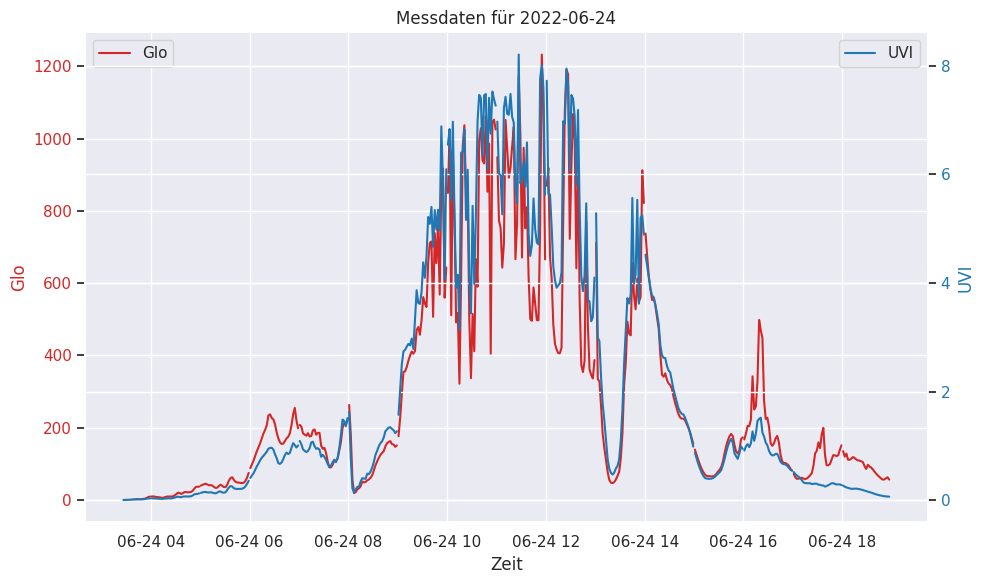

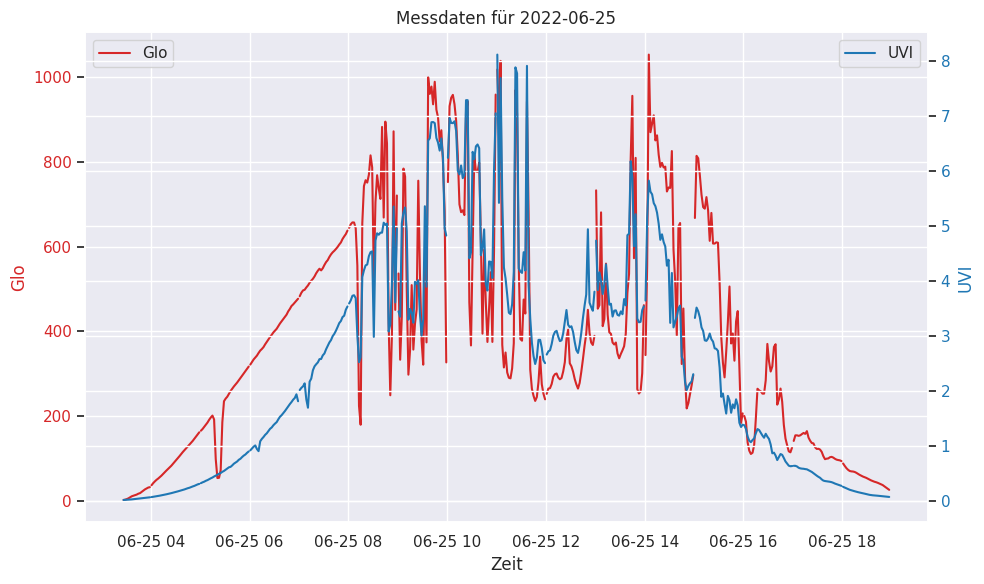

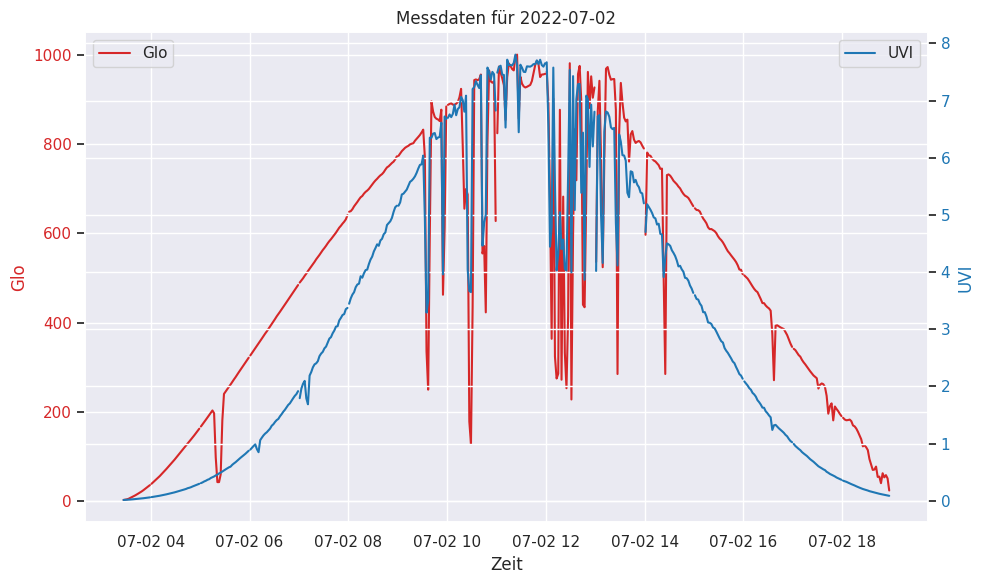

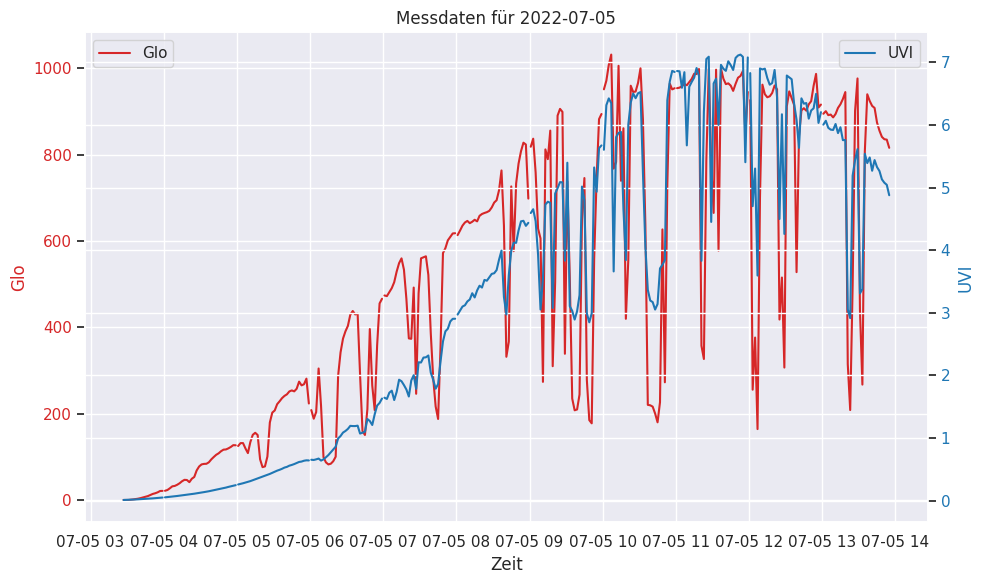

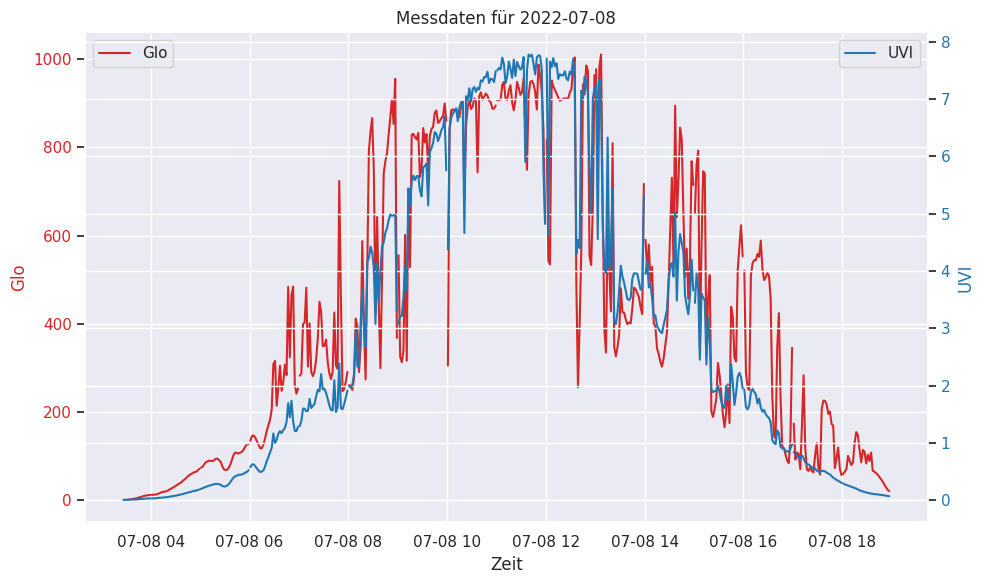

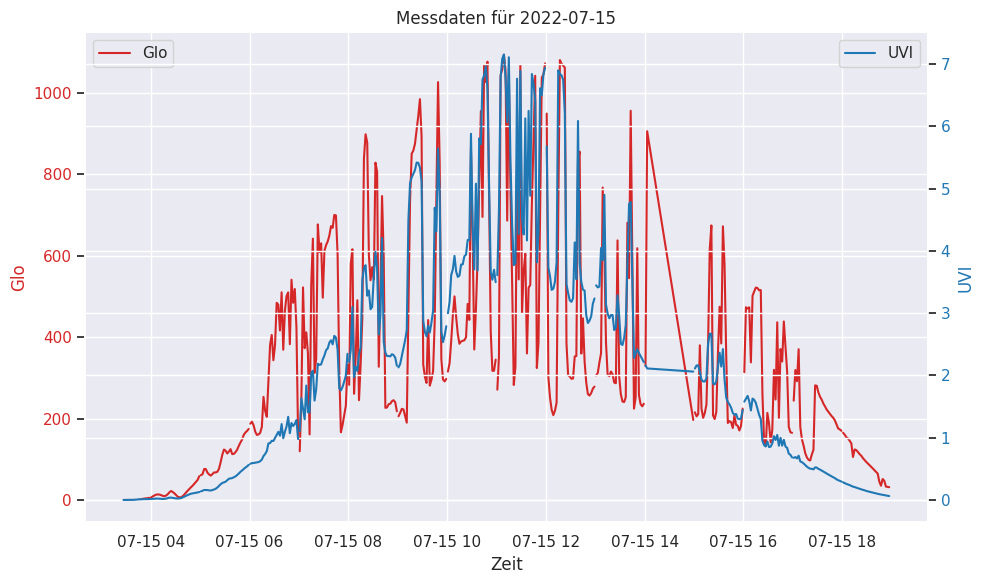

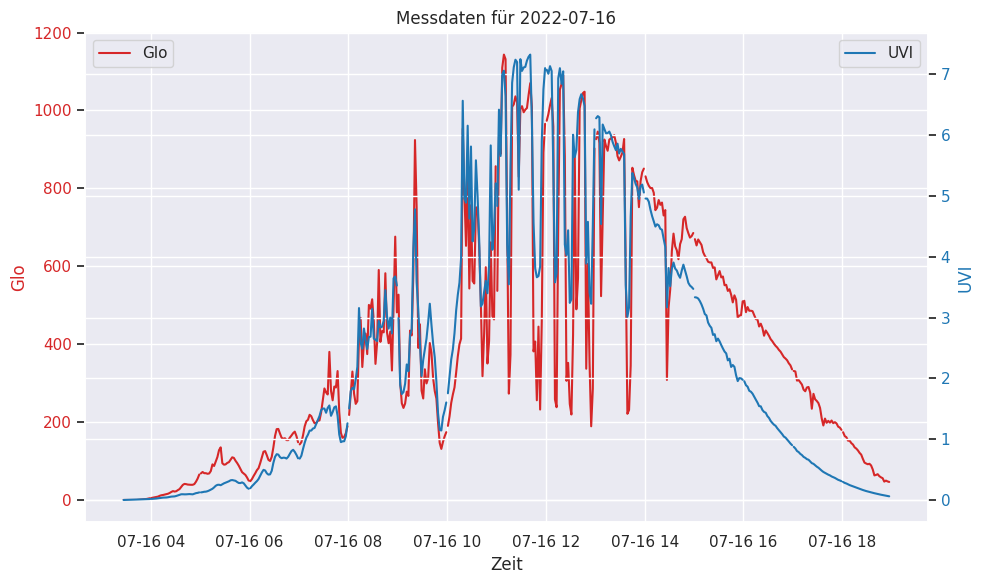

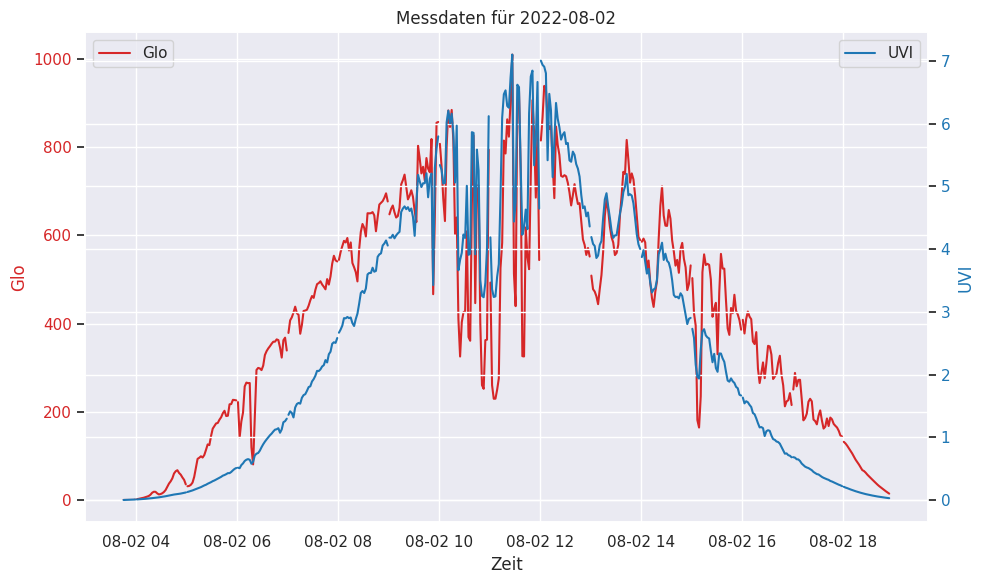

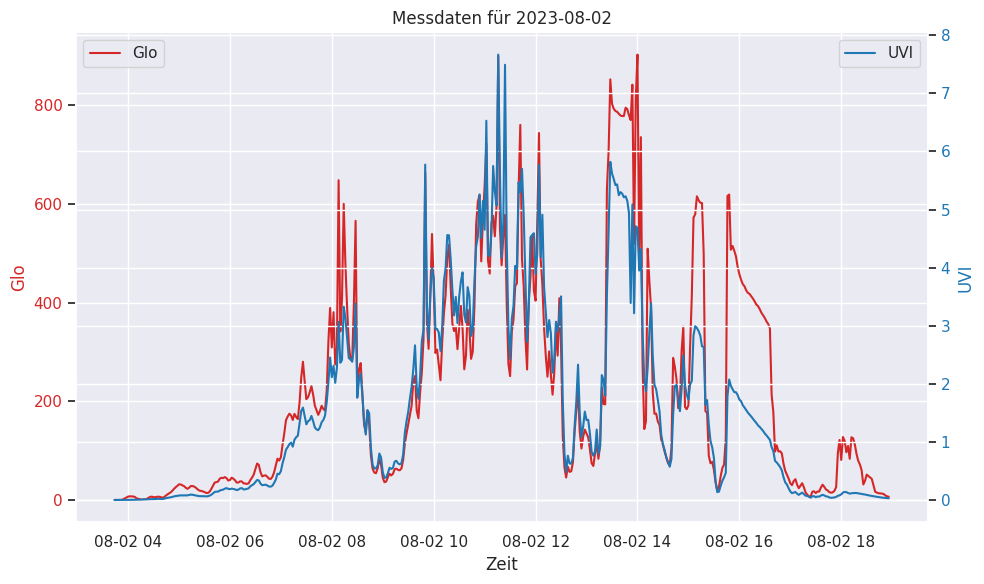

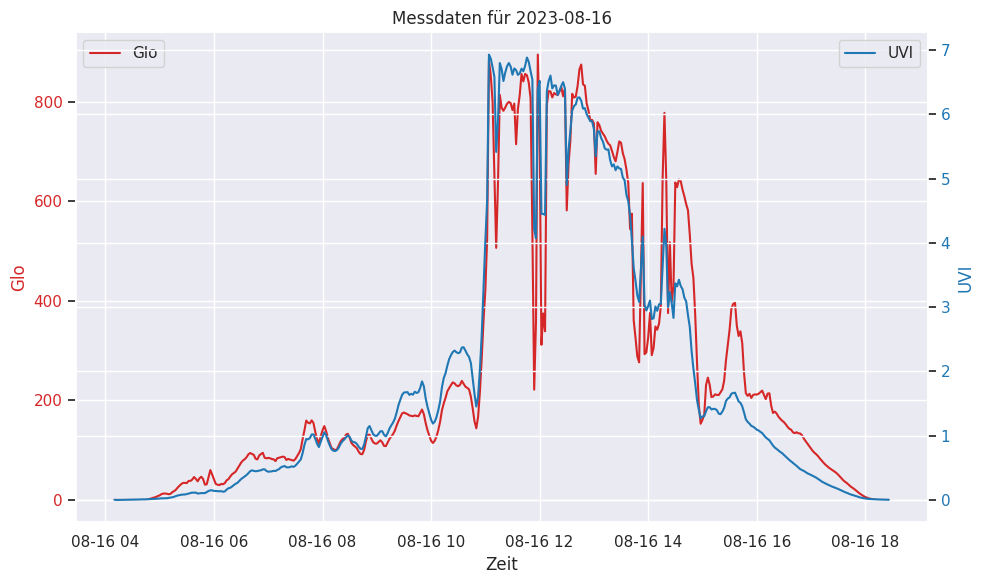

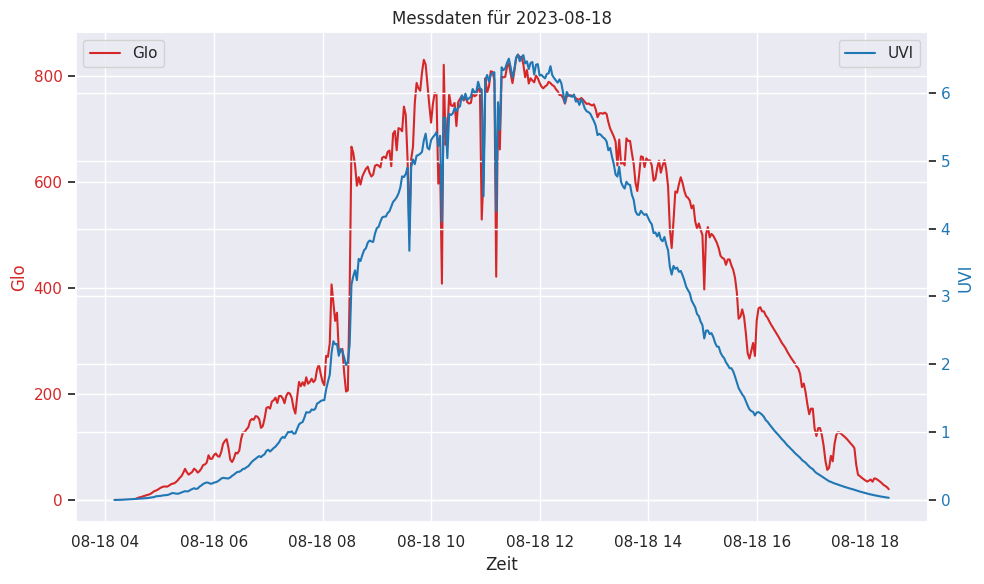

In [54]:
plot_measurements_for_each_day(filter_rows_by_values(df_SolUVI_drop, 'UVI', 6, 'Glo', 600), df_SolUVI_drop, 'Glo', 'UVI')

In [55]:
df_SolUVI_drop2 = df_SolUVI_drop

bin_edges = [25, 40, 50, 60, 70, 80, 100]
df_SolUVI_drop2['SZA_bins'] = pd.cut(df_SolUVI_drop2['SZA'], bins=bin_edges, labels = ['25-40', '40-50', '50-60', '60-70', '70-80', '80-100'])

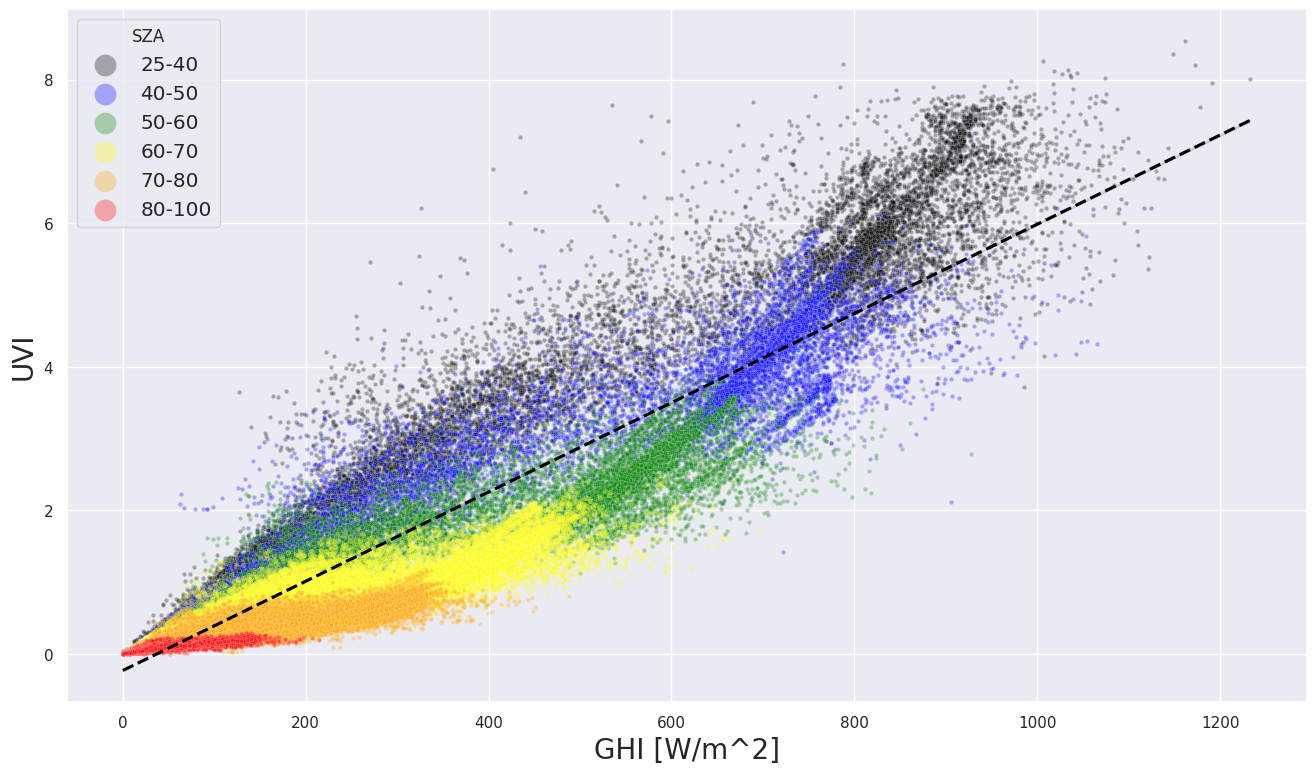

In [56]:
plt.figure(figsize=(16, 9), dpi=100)

colors = ['black', 'blue', 'green', 'yellow', 'orange', 'red']
labels = ['25-40', '40-50', '50-60', '60-70', '70-80', '80-100']

# Sicherstellen, dass die Reihenfolge der Bins und Farben erhalten bleibt
for label, color in zip(labels, colors):
    subset = df_SolUVI_drop2[df_SolUVI_drop2['SZA_bins'] == label]
    sns.scatterplot(data=subset, x='Glo', y='UVI', marker='o', color=color, label=label, s=10, alpha=.3)

# Hinzufügen der Regressionslinie ohne Scatter
sns.regplot(data=df_SolUVI_drop2, x='Glo', y='UVI', line_kws={'color': 'black', 'linestyle': '--'}, scatter=False)

plt.xlabel("GHI [W/m^2]", fontsize=20)
plt.ylabel("UVI", fontsize=20)

plt.legend(title='SZA', scatterpoints=1, fontsize='large', markerscale=5)

plt.savefig('/content/drive/My Drive/Colab_Notebooks/plot_TSA/Korrelation_UVI_GHI.png')
plt.show()
plt.close()

In [57]:
df_SolUVI_drop2[df_SolUVI_drop2['SZA_bins'] == 'Low']

,UVI,SZA,Glo,Dif,Glo_SPLite,Dir,Temp,Var,index_stein,index_coimbra,index_sigma,kc,SZA_bins
Datetime,,,,,,,,,,,,,


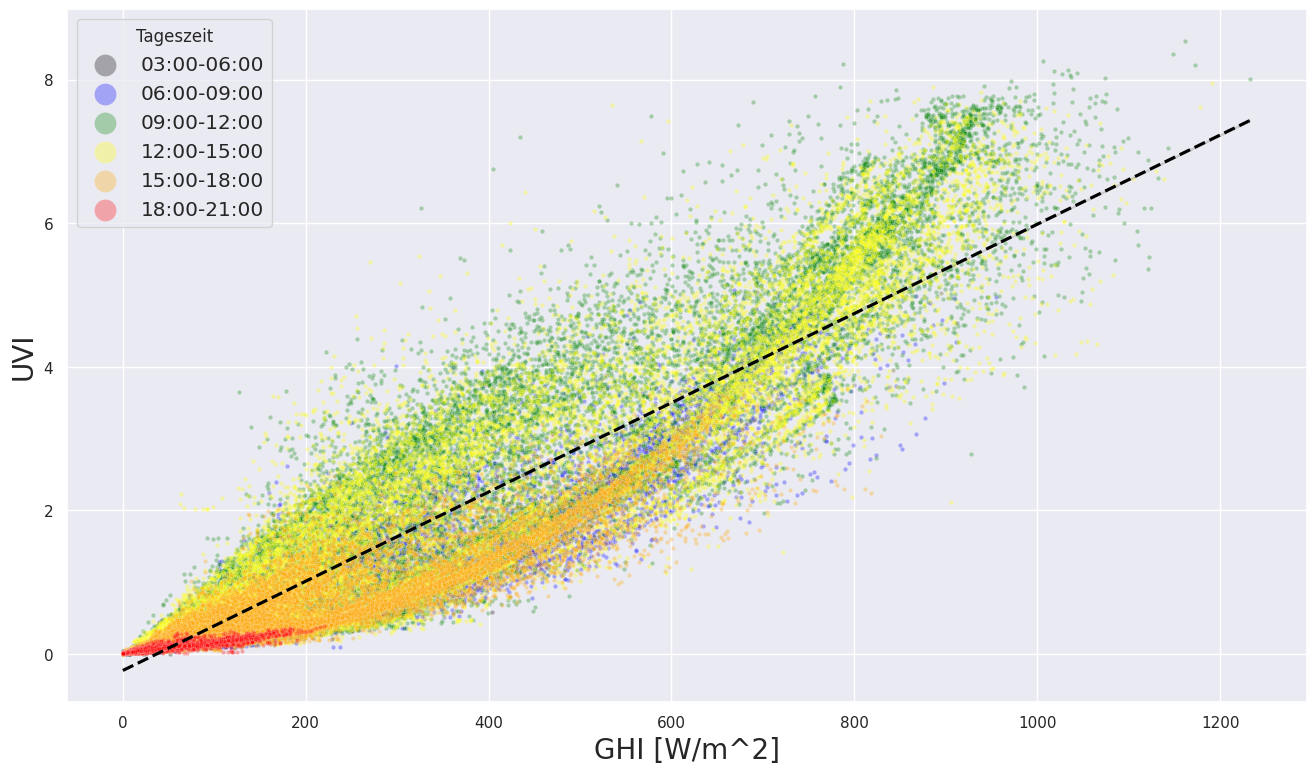

In [58]:
# Schritt 1: Stunden aus dem DateTimeIndex extrahieren
df_SolUVI_drop3 = df_SolUVI_drop

df_SolUVI_drop3['Hour'] = df_SolUVI_drop3.index.hour
colors = ['black', 'blue', 'green', 'yellow', 'orange', 'red']

# Schritt 2: Einteilung der Stunden in Bins
# Hinweis: Die Bins müssen für die Stundenverteilung über den Tag angepasst werden
hour_bins = [3, 6, 9, 12, 15, 18, 21]  # Beispiel für mögliche Bins
hour_labels = ['03:00-06:00', '06:00-09:00', '09:00-12:00', '12:00-15:00', '15:00-18:00', '18:00-21:00']
df_SolUVI_drop3['Time_bins'] = pd.cut(df_SolUVI_drop3['Hour'], bins=hour_bins, labels=hour_labels, right=False)

plt.figure(figsize=(16, 9), dpi=100)

# Schritt 3: Scatterplots für jede Uhrzeit-Kategorie

for label, color in zip(hour_labels, colors):
    subset = df_SolUVI_drop3[df_SolUVI_drop3['Time_bins'] == label]
    sns.scatterplot(data=subset, x='Glo', y='UVI', marker='o', color=color, label=label, s=10, alpha=.3)

# Hinzufügen der Regressionslinie ohne Scatter
sns.regplot(data=df_SolUVI_drop3, x='Glo', y='UVI', line_kws={'color': 'black', 'linestyle': '--'}, scatter=False)

plt.xlabel("GHI [W/m^2]", fontsize=20)
plt.ylabel("UVI", fontsize=20)

plt.legend(title = 'Tageszeit', scatterpoints=1, fontsize='large', markerscale=5)

# Speichern vor der Anzeige
plt.savefig('/content/drive/My Drive/Colab_Notebooks/plot_TSA/Korrelation_UVI_GHI_time.png')
plt.show()
plt.close()

In [59]:
def erweitere_dataframe(df_stuendlich, df_minuetlich, spalten_stuendlich, spalten_minuetlich):
    # Extrahiere die spezifizierten Spalten, plus sicherstellen, dass der Zeitstempel enthalten ist
    if isinstance(df_stuendlich.index, pd.DatetimeIndex):
        df_stuendlich['Zeitstempel'] = df_stuendlich.index
    df_stuendlich = df_stuendlich[['Zeitstempel'] + spalten_stuendlich]

    if isinstance(df_minuetlich.index, pd.DatetimeIndex):
        df_minuetlich['Zeitstempel'] = df_minuetlich.index
    df_minuetlich = df_minuetlich[['Zeitstempel'] + spalten_minuetlich]

    # Sortiere beide Dataframes nach Zeitstempel
    df_stuendlich = df_stuendlich.sort_values(by='Zeitstempel')
    df_minuetlich = df_minuetlich.sort_values(by='Zeitstempel')

    # Verwende merge_asof, um sie basierend auf dem Zeitstempel zu verbinden
    erweiterte_df = pd.merge_asof(df_minuetlich, df_stuendlich, on='Zeitstempel', direction='backward')
    erweiterte_df.set_index('Zeitstempel', inplace=True)

    return erweiterte_df

In [60]:
df_SolUVI_erweitert = []
spalten_stuendlich = ['index_stein', 'index_coimbra', 'index_sigma']
spalten_minuetlich = [ 'UVI', 'Glo']

df_SolUVI_erweitert = erweitere_dataframe(df_VarIdx, df_SolUVI_drop, spalten_stuendlich, spalten_minuetlich)

<Axes: xlabel='index_stein', ylabel='Count'>

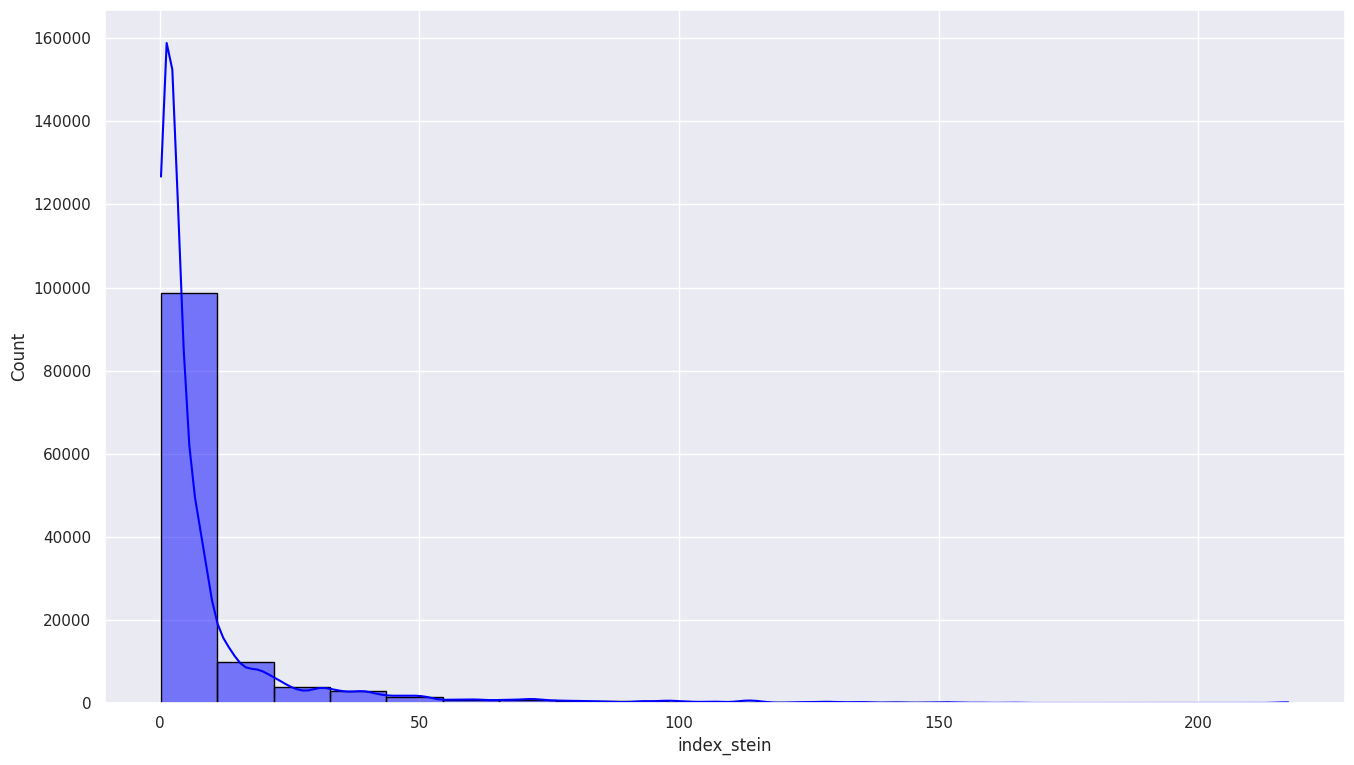

In [61]:
sns.histplot(df_SolUVI_erweitert['index_stein'], kde=True, bins=20, color='blue', edgecolor='black')

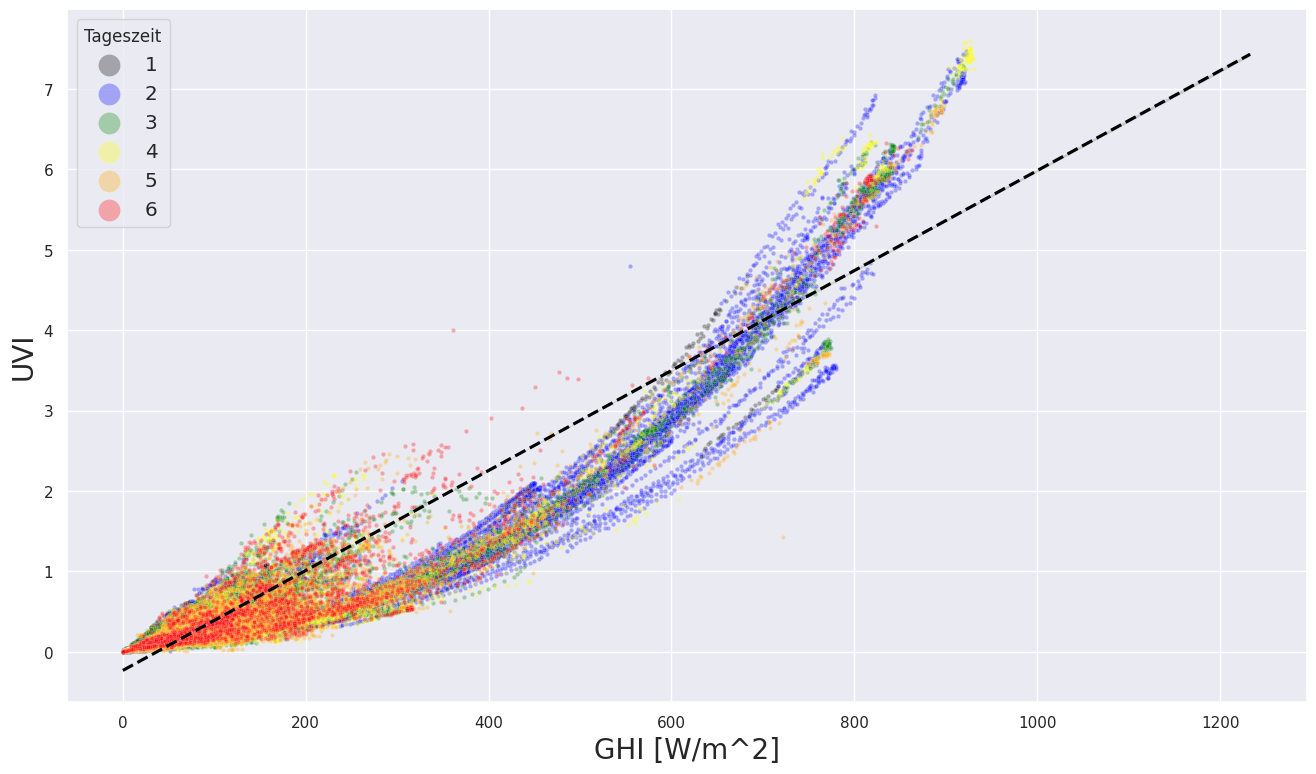

In [62]:
# Schritt 1: Stunden aus dem DateTimeIndex extrahieren
colors = ['black', 'blue', 'green', 'yellow', 'orange', 'red']

# Schritt 2: Einteilung der Stunden in Bins
# Hinweis: Die Bins müssen für die Stundenverteilung über den Tag angepasst werden
#index_bins = [0, 2, 4, 8, 16, 32, 64]  # Beispiel für mögliche Bins
index_bins = [0, 1, 1.5, 2, 2.5, 3, 3.5]
index_labels = ['1', '2', '3', '4', '5', '6']

df_SolUVI_erweitert['index_bins'] = pd.cut(df_SolUVI_erweitert['index_stein'], bins = index_bins, labels = index_labels, right = False)

plt.figure(figsize=(16, 9), dpi=100)

# Schritt 3: Scatterplots für jede Uhrzeit-Kategorie

for label, color in zip(index_labels, colors):
    subset = df_SolUVI_erweitert[df_SolUVI_erweitert['index_bins'] == label]
    sns.scatterplot(data=subset, x='Glo', y='UVI', marker='o', color=color, label=label, s=10, alpha=.3)

# Hinzufügen der Regressionslinie ohne Scatter
sns.regplot(data=df_SolUVI_erweitert, x='Glo', y='UVI', line_kws={'color': 'black', 'linestyle': '--'}, scatter=False)

plt.xlabel("GHI [W/m^2]", fontsize=20)
plt.ylabel("UVI", fontsize=20)

plt.legend(title = 'Tageszeit', scatterpoints=1, fontsize='large', markerscale=5)

# Speichern vor der Anzeige
plt.savefig('/content/drive/My Drive/Colab_Notebooks/plot_TSA/Korrelation_UVI_GHI_Index.png')
plt.show()
plt.close()

In [63]:
df_SolUVI_erweitert['index_bins'] = df_SolUVI_erweitert['index_bins'].astype(float)

In [64]:
df_SolUVI_erweitert.dropna(inplace = True)

In [65]:
coefficients = np.polyfit(df_SolUVI_erweitert['Glo'][df_SolUVI_erweitert['index_bins'] == 2], df_SolUVI_erweitert['UVI'][df_SolUVI_erweitert['index_bins'] == 2], 3)
poly = np.poly1d(coefficients)
x = np.linspace(0, df_SolUVI_erweitert['Glo'].max(), num=100)  # Ersetze 'start' und 'end' durch den Bereich deiner Daten
y = poly(x)

In [66]:
poly

poly1d([6.53165524e-09, 5.61986635e-07, 1.98545568e-03, 3.54143983e-02])

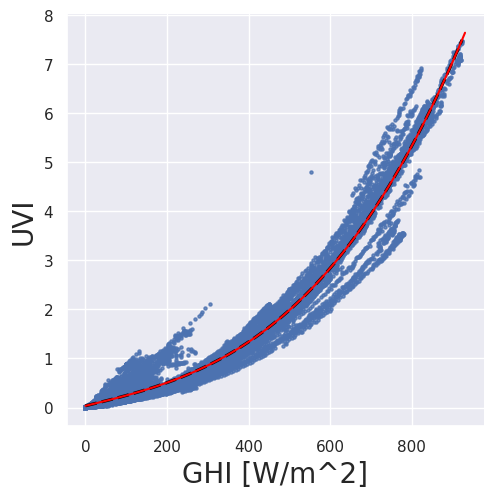

In [67]:
sns.lmplot(data=df_SolUVI_erweitert[df_SolUVI_erweitert['index_bins'] == 2], x='Glo', y='UVI', line_kws={'color': 'black', 'linestyle': '--'}, order=3, ci=None, scatter_kws={'s': 5})
plt.plot(x, y, color='red')

plt.xlabel("GHI [W/m^2]", fontsize=20)
plt.ylabel("UVI", fontsize=20)
plt.savefig('/content/drive/My Drive/Colab_Notebooks/plot_TSA/Korrelation_UVI_GHI_FitFunktion.png')
plt.show()
plt.close()

**Korrelation zwischen der Globalstrahlung und dem UVI. Mit Bezug auf den total cloud cover**

In [68]:
# Datframe für dem Scatterplott mit der Total Cloud Cover anlegen
df_SolUVI_TCC = ['UVI']

In [69]:
df_UVI_hourly

,UVI,erythem,SZA
Datetime,,,
2022-06-15 07:00:00,2.686945,0.067174,53.151062
2022-06-15 08:00:00,4.378194,0.109455,43.431673
2022-06-15 09:00:00,5.684107,0.142103,36.261871
2022-06-15 10:00:00,6.736104,0.168403,30.156914
2022-06-15 11:00:00,7.114456,0.177861,27.689482
...,...,...,...
2023-08-19 01:00:00,NaN,NaN,NaN
2023-08-19 02:00:00,NaN,NaN,NaN
2023-08-19 03:00:00,NaN,NaN,NaN


## Finden von Nullwerten in den UVI Daten

In [70]:
# Zeilen an denen die Solys Daten NaN-Einträge besitzen
df_Solys_UVI_corr[df_Solys_UVI_corr.isnull().any(axis=1)]

,UVI,SZA,Glo,Dif,Glo_SPLite,Dir,Temp,Var,index_stein,index_coimbra,index_sigma,kc
Datetime,,,,,,,,,,,,
2022-06-15 07:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.09551
2022-06-15 07:21:00,2.408378,55.032236,554.483333,72.400000,567.525000,853.966667,27.258333,2,3.245913,0.069262,0.006708,NaN
2022-06-15 07:23:00,2.462381,54.717711,557.791667,73.475000,571.233333,851.991667,28.058333,2,3.245913,0.069262,0.006708,NaN
2022-06-15 07:25:00,2.479048,54.403414,561.708333,74.800000,574.766667,850.225000,28.616667,2,3.245913,0.069262,0.006708,NaN
2022-06-15 07:27:00,2.543531,54.089361,564.783333,75.383333,577.875000,848.400000,26.791667,2,3.245913,0.069262,0.006708,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-19 05:48:00,0.306965,78.036815,232.516667,148.866667,251.808333,419.441667,24.183333,1,2.673958,0.165664,0.021141,NaN
2023-08-19 05:50:00,0.312439,77.722566,233.466667,145.483333,252.866667,426.958333,24.375000,1,2.673958,0.165664,0.021141,NaN
2023-08-19 05:52:00,0.314239,77.408121,215.358333,140.125000,232.941667,356.283333,24.550000,1,2.673958,0.165664,0.021141,NaN


In [71]:
df_Solys_UVI_corr

,UVI,SZA,Glo,Dif,Glo_SPLite,Dir,Temp,Var,index_stein,index_coimbra,index_sigma,kc
Datetime,,,,,,,,,,,,
2022-06-15 07:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.09551
2022-06-15 07:21:00,2.408378,55.032236,554.483333,72.400000,567.525000,853.966667,27.258333,2,3.245913,0.069262,0.006708,NaN
2022-06-15 07:23:00,2.462381,54.717711,557.791667,73.475000,571.233333,851.991667,28.058333,2,3.245913,0.069262,0.006708,NaN
2022-06-15 07:25:00,2.479048,54.403414,561.708333,74.800000,574.766667,850.225000,28.616667,2,3.245913,0.069262,0.006708,NaN
2022-06-15 07:27:00,2.543531,54.089361,564.783333,75.383333,577.875000,848.400000,26.791667,2,3.245913,0.069262,0.006708,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-19 05:48:00,0.306965,78.036815,232.516667,148.866667,251.808333,419.441667,24.183333,1,2.673958,0.165664,0.021141,NaN
2023-08-19 05:50:00,0.312439,77.722566,233.466667,145.483333,252.866667,426.958333,24.375000,1,2.673958,0.165664,0.021141,NaN
2023-08-19 05:52:00,0.314239,77.408121,215.358333,140.125000,232.941667,356.283333,24.550000,1,2.673958,0.165664,0.021141,NaN
